In [1]:
from matplotlib import pyplot as plt

import numpy as np
np.random.seed(42)
import random
random.seed(42)

# Question 1

Fetch dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics',
              'comp.sys.mac.hardware', 'comp.os.ms-windows.misc',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

Create TF-IDF matrix

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# count
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_counts = vectorizer.fit_transform(dataset.data)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print("Dimension of TF-IDF matrix is ",X_tfidf.shape)

('Dimension of TF-IDF matrix is ', (7882, 27768))


# Question 2

K-means directly on full-dimension data

In [4]:
from sklearn.cluster import KMeans
from sklearn import metrics

km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30, init='k-means++')
km.fit(X_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=30, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [5]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i,)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
('Cluster 0:',)
 edu
 game
 team
 ca
 games
 year
 hockey
 players
 baseball
 writes
('Cluster 1:',)
 edu
 com
 subject
 lines
 organization
 windows
 university
 posting
 host
 nntp


Overwrite original labels with bin labels

In [6]:
_, idx = np.unique(dataset.target, return_index=True)
for i in range(len(idx)):
    print(dataset.target_names[i],': target index = ', dataset.target[idx[i]])    

('comp.graphics', ': target index = ', 0)
('comp.os.ms-windows.misc', ': target index = ', 1)
('comp.sys.ibm.pc.hardware', ': target index = ', 2)
('comp.sys.mac.hardware', ': target index = ', 3)
('rec.autos', ': target index = ', 4)
('rec.motorcycles', ': target index = ', 5)
('rec.sport.baseball', ': target index = ', 6)
('rec.sport.hockey', ': target index = ', 7)


In [7]:
labels = np.zeros_like(dataset.target)
for y in [4,5,6,7]:
    labels[np.argwhere(dataset.target == y)] = 0
for y in [0,1,2,3]:
    labels[np.argwhere(dataset.target == y)] = 1    
class_names = ['Recreational Activity', 'Computer Technology']

cm = metrics.cluster.contingency_matrix(labels, km.labels_)

In [8]:
import itertools
def plot_contingency_matrix(cm, classes,
                          normalize=False,
                          title='Contingency matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the contingency matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum()
        print("Normalized Contingency matrix")
    else:
        print('Contingency matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Contingency matrix, without normalization
[[1718 2261]
 [   4 3899]]


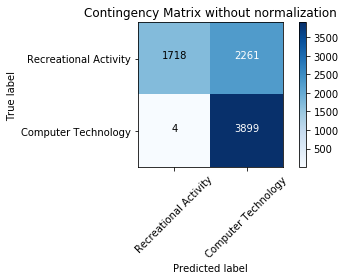

In [9]:
plt.figure()
plot_contingency_matrix(cm, classes=class_names, normalize=False,
                      title='Contingency Matrix without normalization')

plt.show()

# Question 3

In [10]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

Homogeneity: 0.254
Completeness: 0.335
V-measure: 0.289
Adjusted Rand-Index: 0.181
adjusted_mutual_info_score: 0.254


# Question 4

In [11]:
from sklearn.decomposition import TruncatedSVD
import heapq

svd = TruncatedSVD(n_components=1000, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

From i=1000 to 1, choose the first i-th most significant features

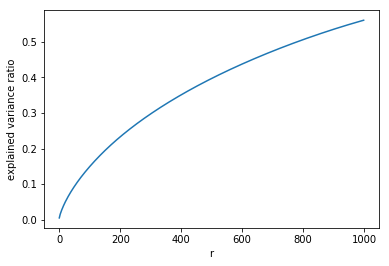

In [12]:
import heapq
evr = np.zeros(1000)
for i in range(1000,0,-1):
    evr[i-1] = np.array(heapq.nlargest(i,svd.explained_variance_ratio_)).sum()
plt.xlabel("r")
plt.ylabel("explained variance ratio")
plt.plot(evr)

# Question 5

In [13]:
r_list = [1,2,3,5,10,20,50,100,300]

homo = np.zeros(9)
comp = np.zeros(9)
vmea = np.zeros(9)
ari = np.zeros(9)
ami = np.zeros(9)

Using truncated SVD

In [14]:
for i,r in enumerate(r_list):
    # compute X_reduced
    svd = TruncatedSVD(n_components=r, random_state=42)
    X_reduced = svd.fit_transform(X_tfidf)
    # do K-means on X_reduced
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30, init='k-means++')
    km.fit(X_reduced)
    # evaluate using 5 measure scores
    homo[i] = metrics.homogeneity_score(labels, km.labels_)
    comp[i] = metrics.completeness_score(labels, km.labels_)
    vmea[i] = metrics.v_measure_score(labels, km.labels_)
    ari[i] = metrics.adjusted_rand_score(labels, km.labels_)
    ami[i] = metrics.adjusted_mutual_info_score(labels, km.labels_)       

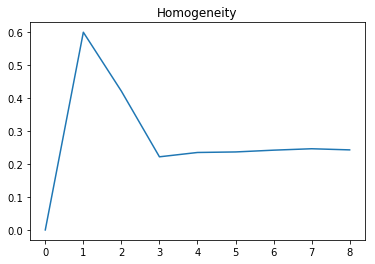

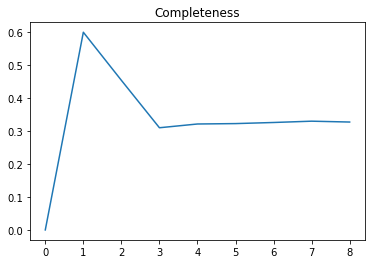

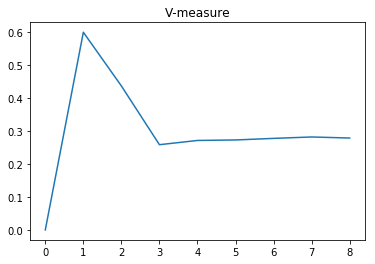

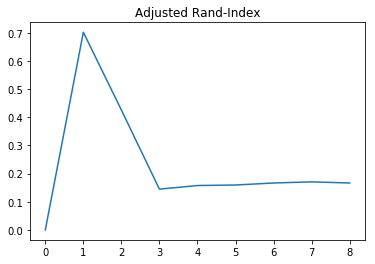

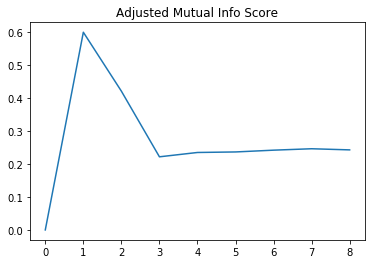

In [15]:
plt.figure();plt.plot(homo);plt.title("Homogeneity")
plt.figure();plt.plot(comp);plt.title("Completeness")
plt.figure();plt.plot(vmea);plt.title("V-measure")
plt.figure();plt.plot(ari);plt.title("Adjusted Rand-Index")
plt.figure();plt.plot(ami);plt.title("Adjusted Mutual Info Score")

plt.show()

Using NMF

In [16]:
from sklearn.decomposition import NMF

for i,r in enumerate(r_list):
    # compute X_reduced
    nmf = NMF(n_components=r, init='random', random_state=42)
    X_reduced = nmf.fit_transform(X_tfidf)
    # do K-means on X_reduced
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30, init='k-means++')
    km.fit(X_reduced)
    # evaluate using 5 measure scores
    homo[i] = metrics.homogeneity_score(labels, km.labels_)
    comp[i] = metrics.completeness_score(labels, km.labels_)
    vmea[i] = metrics.v_measure_score(labels, km.labels_)
    ari[i] = metrics.adjusted_rand_score(labels, km.labels_)
    ami[i] = metrics.adjusted_mutual_info_score(labels, km.labels_)    

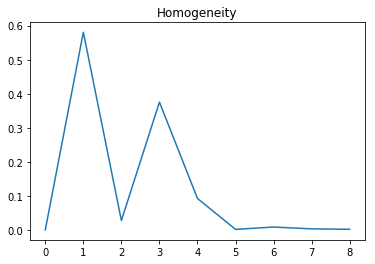

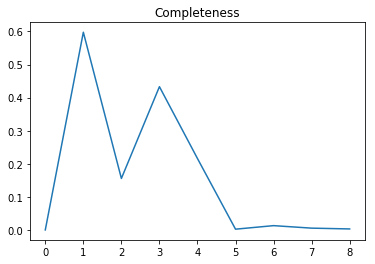

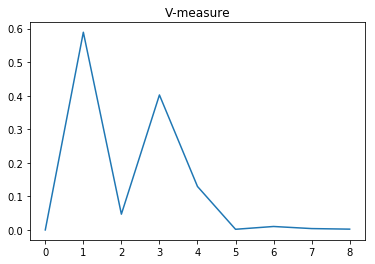

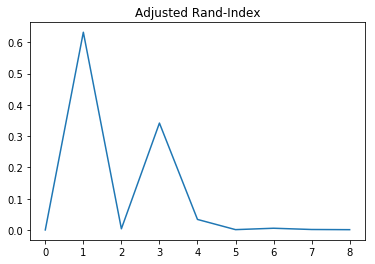

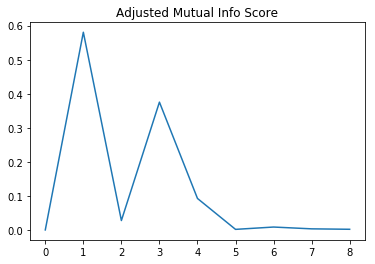

In [17]:
plt.figure();plt.plot(homo);plt.title("Homogeneity")
plt.figure();plt.plot(comp);plt.title("Completeness")
plt.figure();plt.plot(vmea);plt.title("V-measure")
plt.figure();plt.plot(ari);plt.title("Adjusted Rand-Index")
plt.figure();plt.plot(ami);plt.title("Adjusted Mutual Info Score")

plt.show()

# Question 6

Results from both PCA and NMF show that the best number of feature components is 2. According to paper Ding & He 2004, K-means can be seen as a super-sparse PCA. The agreement between K-means and PCA is quite good, they maximize the same objective function, with the only difference being that K-means has additional "categorical" constraint. So in our test case of K-means with 2 classes, it is reasonable that PCA with n_components = 2 has the best result. As the number of truncated feature goes up, the curse of high dimension appears, thus all 5 measured coefficients goes down.

# Question 7

In [107]:
def dim_reduce(svd_NMF,r_best,X=X_tfidf):
    if svd_NMF==1:
        svd = TruncatedSVD(n_components=r_best, random_state=42)
        X_vis = svd.fit_transform(X)
        km_vis = KMeans(n_clusters=2, init='k-means++',n_init=30, max_iter=1000, random_state=0)
        km_vis.fit(X_vis) 
        title='(SVD)'
    else:
        model = NMF(n_components=r_best, init='random', random_state=42)
        X_vis = model.fit_transform(X)
        km_vis = KMeans(n_clusters=2, init='k-means++',n_init=30, max_iter=1000, random_state=0)
        km_vis.fit(X_vis)
        title='(NMF)'
    #reduced to 2d
    if r_best>2:
        svd_vis=TruncatedSVD(n_components=2, random_state=42)
        X_vis=svd_vis.fit_transform(X_reduced)
    
    return X_vis,km_vis,title

In [108]:
def visualization(X_vis,km_vis,title):
    plt.figure()
    color=[]
    for i in range(X_vis.shape[0]):
        color.append([0.5*(1-km_vis.labels_[i]),0.5,0.5])
    plt.scatter(X_vis[:,0],X_vis[:,1],s=1,color=color)
    title1='Clustering label'+title
    plt.xlabel(title1)
    plt.figure()   
    color=[]
    for i in range(X_vis.shape[0]):
        color.append([0.5*labels[i],0.5,0.5])
    plt.scatter(X_vis[:,0],X_vis[:,1],s=1,color=color)
    title1='Ground truth class label'+title
    plt.xlabel(title1)
    plt.show()

Plot using truncated SVD

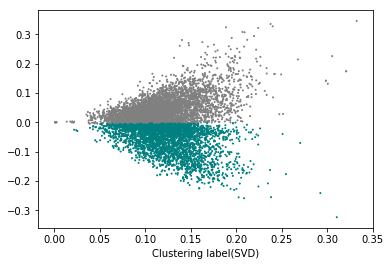

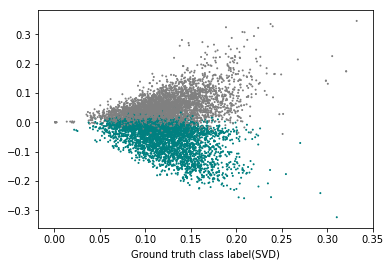

Homogeneity: 0.598
Completeness: 0.599
V-measure: 0.599
Adjusted Rand-Index: 0.702
adjusted_mutual_info_score: 0.598


In [117]:
r_best_svd = 2
X_reduced_svd, km_svd, title1 = dim_reduce(1,r_best_svd)
visualization(X_reduced_svd, km_svd, title1)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km_svd.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km_svd.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km_svd.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km_svd.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km_svd.labels_))

Plot using NMF

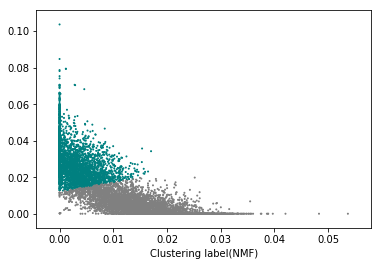

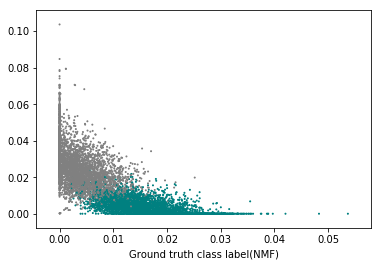

Homogeneity: 0.581
Completeness: 0.598
V-measure: 0.589
Adjusted Rand-Index: 0.632
adjusted_mutual_info_score: 0.581


In [123]:
r_best_nmf = 2
X_reduced_nmf, km_nmf, title2 = dim_reduce(0,r_best_nmf)
visualization(X_reduced_nmf, km_nmf, title2)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km_nmf.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km_nmf.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km_nmf.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km_nmf.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km_nmf.labels_))

# Question 8-10

In [124]:
def zero_var(X):
    return (X-X.mean(axis=0))/X.std(axis=0)

def transform(X,c=0.01):
    return np.multiply(np.sign(X),(np.log(abs(X)+c)-np.log(c)))

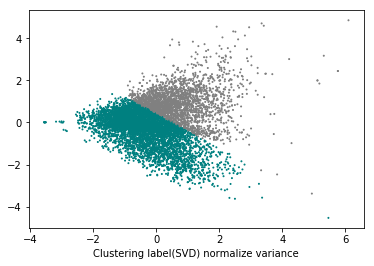

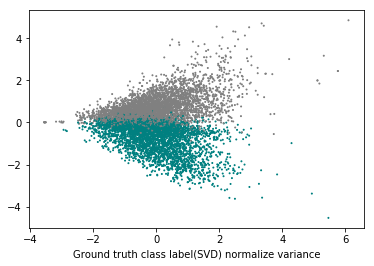

Homogeneity: 0.235
Completeness: 0.263
V-measure: 0.248
Adjusted Rand-Index: 0.255
adjusted_mutual_info_score: 0.235


In [134]:
# SVD normalize variance

X = zero_var(X_reduced_svd)
km = KMeans(n_clusters=2, init='k-means++',n_init=30, max_iter=1000, random_state=0)
km.fit(X) 
visualization(X,km,'(SVD) normalize variance')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

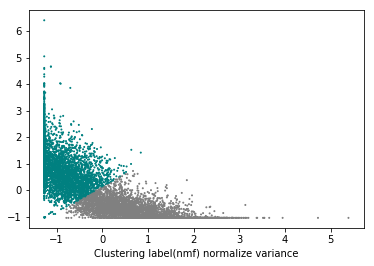

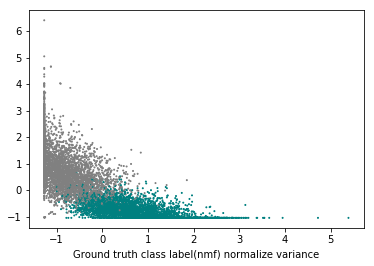

Homogeneity: 0.683
Completeness: 0.686
V-measure: 0.684
Adjusted Rand-Index: 0.773
adjusted_mutual_info_score: 0.683


In [135]:
# nmf normalize variance

X = zero_var(X_reduced_nmf)
km = KMeans(n_clusters=2, init='k-means++',n_init=30, max_iter=1000, random_state=0)
km.fit(X) 
visualization(X,km,'(nmf) normalize variance')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

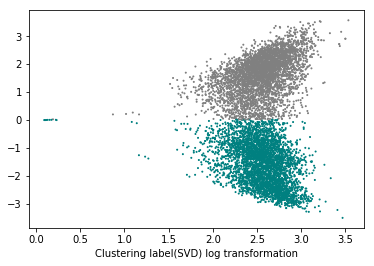

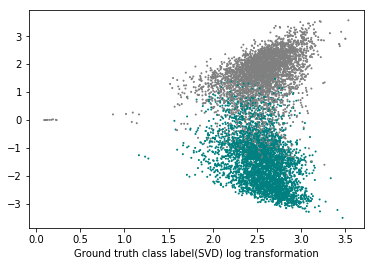

Homogeneity: 0.602
Completeness: 0.602
V-measure: 0.602
Adjusted Rand-Index: 0.710
adjusted_mutual_info_score: 0.602


In [136]:
# SVD log transformation

X = transform(X_reduced_svd)
km = KMeans(n_clusters=2, init='k-means++',n_init=30, max_iter=1000, random_state=0)
km.fit(X) 
visualization(X,km,'(SVD) log transformation')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

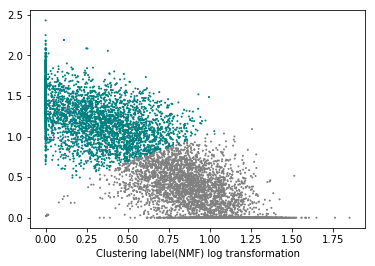

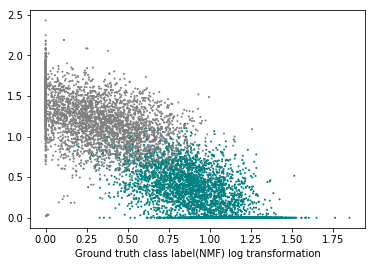

Homogeneity: 0.701
Completeness: 0.702
V-measure: 0.701
Adjusted Rand-Index: 0.796
adjusted_mutual_info_score: 0.701


In [137]:
# NMF log transformation

X = transform(X_reduced_nmf)
km = KMeans(n_clusters=2, init='k-means++',n_init=30, max_iter=1000, random_state=0)
km.fit(X) 
visualization(X,km,'(NMF) log transformation')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

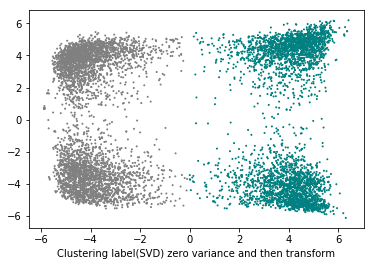

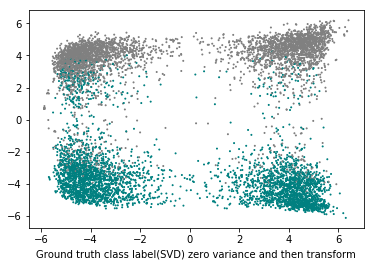

Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand-Index: -0.000
adjusted_mutual_info_score: -0.000


In [138]:
# SVD zero variance and then transform

X = transform(zero_var(X_reduced_svd))
km = KMeans(n_clusters=2, init='k-means++',n_init=30, max_iter=1000, random_state=0)
km.fit(X) 
visualization(X,km,'(SVD) zero variance and then transform')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

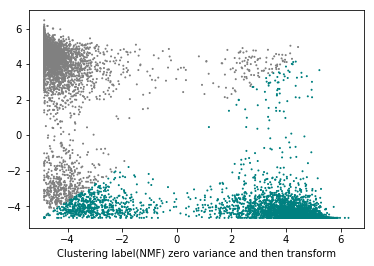

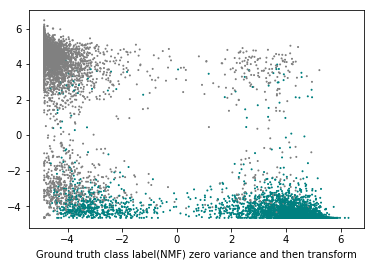

Homogeneity: 0.693
Completeness: 0.695
V-measure: 0.694
Adjusted Rand-Index: 0.785
adjusted_mutual_info_score: 0.693


In [139]:
# NMF zero variance and then transform

X = transform(zero_var(X_reduced_nmf))
km = KMeans(n_clusters=2, init='k-means++',n_init=30, max_iter=1000, random_state=0)
km.fit(X) 
visualization(X,km,'(NMF) zero variance and then transform')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

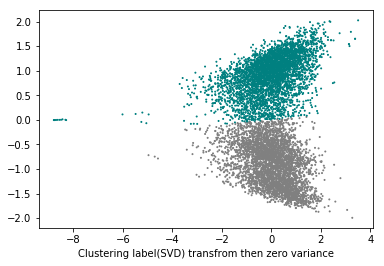

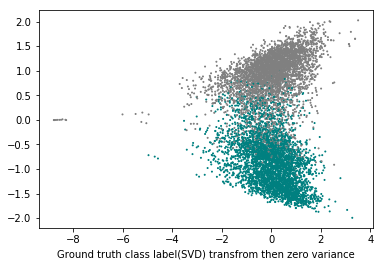

Homogeneity: 0.606
Completeness: 0.606
V-measure: 0.606
Adjusted Rand-Index: 0.713
adjusted_mutual_info_score: 0.605


In [140]:
# SVD transfrom then zero variance

X = zero_var(transform(X_reduced_svd))
km = KMeans(n_clusters=2, init='k-means++',n_init=30, max_iter=1000, random_state=0)
km.fit(X) 
visualization(X,km,'(SVD) transfrom then zero variance')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

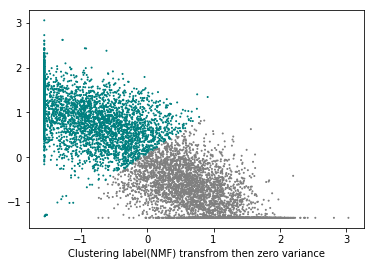

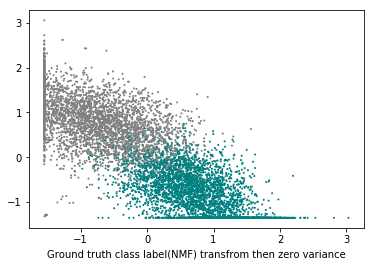

Homogeneity: 0.704
Completeness: 0.705
V-measure: 0.704
Adjusted Rand-Index: 0.799
adjusted_mutual_info_score: 0.704


In [141]:
# NMF transfrom then zero variance

X = zero_var(transform(X_reduced_nmf))
km = KMeans(n_clusters=2, init='k-means++',n_init=30, max_iter=1000, random_state=0)
km.fit(X) 
visualization(X,km,'(NMF) transfrom then zero variance')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))